'imagenet_classes.txt'에서 1000개 라벨 로드 완료.
'img_resnet' 폴더에서 찾은 이미지 개수: 101장
Processed image: 10.jpeg, Top 1 Prediction: cock (Score: 0.6521)

Classification Results:
- cock: 0.6521
- hen: 0.3080
- peacock: 0.0072
- goose: 0.0034
- prairie_chicken: 0.0027


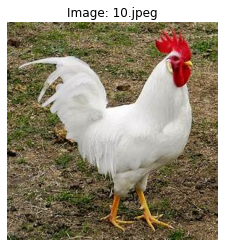

Processed image: 1.jpeg, Top 1 Prediction: lynx (Score: 0.4669)
Processed image: 10.jpeg, Top 1 Prediction: cock (Score: 0.6521)
Processed image: 14.jpeg, Top 1 Prediction: European_gallinule (Score: 0.8492)
Processed image: 16.jpeg, Top 1 Prediction: hen (Score: 0.8545)
Processed image: 17.jpeg, Top 1 Prediction: hen (Score: 0.8563)
Processed image: 19.jpeg, Top 1 Prediction: cock (Score: 0.5057)
Processed image: 2.jpeg, Top 1 Prediction: European_gallinule (Score: 0.3353)
Processed image: 4.jpeg, Top 1 Prediction: hen (Score: 0.9134)
Processed image: 5.jpeg, Top 1 Prediction: hen (Score: 0.9614)
Processed image: 6.jpeg, Top 1 Prediction: hen (Score: 0.5481)
Processed image: 76.jpeg, Top 1 Prediction: Egyptian_cat (Score: 0.1440)
Processed image: 77.jpeg, Top 1 Prediction: Chihuahua (Score: 0.1291)
Processed image: 78.jpeg, Top 1 Prediction: tabby (Score: 0.1454)
Processed image: 80.jpeg, Top 1 Prediction: Egyptian_cat (Score: 0.2484)
Processed image: 81.jpeg, Top 1 Prediction: Egypti

Processed image: OIP-2SxBWLq3JZHphB2xxkXI7QAAAA.jpeg, Top 1 Prediction: fox_squirrel (Score: 0.3624)
Processed image: OIP-2T1yupCVWmzn_mHjv6ohYQAAAA.jpeg, Top 1 Prediction: fox_squirrel (Score: 0.9984)
Processed image: OIP-2TINkS3ll-8tysV3MByFyAHaEy.jpeg, Top 1 Prediction: mink (Score: 0.4688)
Processed image: OIP-2TJq1a5oDSMHM50S7F3E8wHaE6.jpeg, Top 1 Prediction: mongoose (Score: 0.3709)
Processed image: OIP-2US-P_A_FNsJWVQ2JyleCAHaE8.jpeg, Top 1 Prediction: fox_squirrel (Score: 0.7203)
Processed image: OIP-2UhoxAp1zf5nB64TKmtZKQAAAA.jpeg, Top 1 Prediction: fox_squirrel (Score: 0.8608)
Processed image: OIP-2Z5nlZgwG9U7KQlYiPGj5gHaJA.jpeg, Top 1 Prediction: fox_squirrel (Score: 0.9938)
Processed image: OIP-2__NpI2rLlo-FYlj7h-fNwHaE7.jpeg, Top 1 Prediction: fox_squirrel (Score: 0.9709)
Processed image: OIP-2cHYMnL2pk4WwKlAylqVWQAAAA.jpeg, Top 1 Prediction: fox_squirrel (Score: 0.5885)
DPU Performance: 19.63 FPS (5.14 seconds for 101 images)


In [2]:
#!/usr/bin/env python
# coding: utf-8

# # DPU example: Resnet50
# ----

# ## Aim/s
# * This notebooks shows an example of DPU applications. The application,as well as the DPU IP, is pulled from the official 
# [Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).
# 
# ## References
# * [Vitis AI Github Repository](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).
# 
# ## Last revised
# * Mar 3, 2021
#     * Initial revision
# * Dec 17, 2021
#     * Calling load_model after importing cv2 to avoid memory allocation issues on KV260
# ----

# ## 1. Prepare the overlay
# We will download the overlay onto the board. 

# In[2]:


from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")


# ## 2. Utility functions
# 
# In this section, we will prepare a few functions for later use.

# In[3]:


import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ImageNet 클래스 ID와 이름 매핑 (decode_predictions 대체)
# 'imagenet_classes.txt' 파일을 사용하여 라벨을 로드합니다.
# 이 파일은 각 라인에 '클래스_번호, 클래스_이름' 형식을 가집니다.
IMAGENET_LABELS = {}
label_file_path = 'imagenet_classes.txt' # 사용자 지정 파일명

if os.path.exists(label_file_path):
    with open(label_file_path, 'r') as f:
        for line in f: # 모든 라인을 읽습니다.
            line = line.strip()
            if not line: continue # 빈 줄 건너뛰기

            # 라인이 '숫자, 클래스이름' 형식인지 확인합니다.
            # 숫자로 시작하고 콤마를 포함하는 유효한 라벨 라인만 파싱합니다.
            parts = line.split(',', 1) # 첫 번째 콤마 기준으로 분할
            if len(parts) == 2 and parts[0].strip().isdigit():
                try:
                    class_id = int(parts[0].strip())
                    class_name = parts[1].strip()
                    # ImageNet 'n' ID는 이 파일에 없으므로, 필요하면 'n' + 숫자 ID 형태로 생성합니다.
                    IMAGENET_LABELS[class_id] = ('n' + str(class_id).zfill(8), class_name)
                except ValueError:
                    # 숫자로 시작했지만 파싱이 안 되는 경우 (매우 드뭄)
                    print(f"경고: '{label_file_path}' 파일의 잘못된 형식 라인 (숫자 파싱 오류): {line}")
            else:
                pass # 유효한 라벨이 아니면 아무것도 하지 않고 건너뜠습니다.

    print(f"'{label_file_path}'에서 {len(IMAGENET_LABELS)}개 라벨 로드 완료.")
else:
    print(f"경고: '{label_file_path}' 파일을 찾을 수 없습니다. 라벨 매핑이 불완전할 수 있습니다.")
    # 파일이 없을 경우 최소한의 하드코딩된 라벨을 사용합니다. 실제 사용 시에는 전체 라벨을 포함해야 합니다.
    IMAGENET_LABELS = {
        0: ('n01440764', 'tench'),
        1: ('n01443537', 'goldfish'),
        2: ('n01484850', 'great_white_shark'),
        281: ('n02391049', 'zebra'),
        339: ('n02883203', 'bobsled'),
        397: ('n04067472', 'remote_control'),
        999: ('n04596000', 'wooden_spoon'),
    }

try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except NameError:
    pass # Jupyter Notebook 환경이 아니면 에러 무시


# The `load_model()` method will automatically prepare the `graph`
# which is used by VART.
# 
# **Note** For the KV260 board you may see TLS memory allocation errors if cv2 gets loaded before loading the vitis libraries in the Jupyter Lab environment. Make sure to load cv2 first in these cases.

# In[4]:


overlay.load_model("dpu_resnet50.xmodel")
#overlay.load_model("MLPerf_resnet50_v1.5_tf.xmodel")


# Let's first define a few useful preprocessing functions. These functions
# will make sure the DPU can take input images with arbitrary sizes.

# In[5]:


_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

MEANS = [_B_MEAN,_G_MEAN,_R_MEAN]

def resize_shortest_edge(image, size):
    H, W = image.shape[:2]
    if H >= W:
        nW = size
        nH = int(float(H)/W * size)
    else:
        nH = size
        nW = int(float(W)/H * size)
    return cv2.resize(image,(nW,nH))

def mean_image_subtraction(image, means):
    B, G, R = cv2.split(image)
    B = B - means[0]
    G = G - means[1]
    R = R - means[2]
    image = cv2.merge([R, G, B])
    return image

def BGR2RGB(image):
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    return image

def central_crop(image, crop_height, crop_width):
    image_height = image.shape[0]
    image_width = image.shape[1]
    offset_height = (image_height - crop_height) // 2
    offset_width = (image_width - crop_width) // 2
    return image[offset_height:offset_height + crop_height, offset_width:
                 offset_width + crop_width, :]

def normalize(image):
    image=image/256.0
    image=image-0.5
    image=image*2
    return image

def preprocess_fn(image, crop_height = 224, crop_width = 224):
    image = resize_shortest_edge(image, 256)
    image = mean_image_subtraction(image, MEANS)
    image = central_crop(image, crop_height, crop_width)
    return image


# We will also define a few functions to calculate softmax and provide 
# the output class after running a DPU task.

# In[6]:


def calculate_softmax(data):
    result = np.exp(data - np.max(data)) # 오버플로우 방지를 위해 max 값 빼기
    return result / np.sum(result) # 확률 합이 1이 되도록 정규화

def predict_label(softmax_output, top_k=5):
    # softmax_output은 (1000,) 형태의 확률 배열이어야 합니다.
    # 확률이 높은 순서대로 인덱스를 가져옵니다.
    top_indices = np.argsort(softmax_output)[::-1][:top_k]
    
    results = []
    for i in top_indices:
        # IMAGENET_LABELS 딕셔너리에서 클래스 ID로 라벨 정보 조회
        class_id_info = IMAGENET_LABELS.get(i, ('unknown', f'Unknown Class {i}')) 
        label = class_id_info[1] # 클래스 이름 (예: 'tench')
        score = softmax_output[i] # 해당 클래스의 확률
        results.append((label, score))
        
    return results


# Keep in mind that our original images are 640x480 so we need to preprocess them
# later to make sure it fits our model.

# In[7]:


# In[7]:

# image_folder = 'img'
image_folder = 'img_resnet'

# 지원하는 이미지 파일 확장자 필터링 (소문자/대문자 모두 인식)
original_images = sorted([i for i in os.listdir(image_folder)
                          if i.lower().endswith((".jpeg", ".jpg", ".png"))])
total_images = len(original_images)

print(f"'{image_folder}' 폴더에서 찾은 이미지 개수: {total_images}장")
if total_images == 0:
    print("경고: 이미지를 찾을 수 없습니다. 폴더 경로와 파일 확장자를 확인하세요.")


# ## 3. Use VART
# Now we should be able to use VART to do image classification.

# In[8]:


dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

# softmax = np.empty(outputSize) # 이 변수는 run 함수 내에서 지역적으로 사용될 것이므로 여기서는 제거


# We can define a few buffers to store input and output data. They will be reused
# during multiple runs.

# In[9]:


output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]


# Remember that we have a list of `original_images`. 
# We can now define a new function `run()` which takes the image index as 
# the input, and calculate the softmax as the classification result.
# With the argument `display` set to `True`, the original image as well as the
# predicted label can be rendered.
# 
# It is obvious that the range of `image_index` should be [0, `total_images`-1].

# In[10]:


def run(image_index, display=False):
    image_file_name = original_images[image_index]
    image_path = os.path.join(image_folder, image_file_name)

    preprocessed = preprocess_fn(cv2.imread(image_path))
    image[0,...] = preprocessed.reshape(shapeIn[1:])
    
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax_output = calculate_softmax(temp[0][0])
    
    # 수정된 predict_label 함수를 사용하여 결과 가져오기
    results = predict_label(softmax_output, top_k=1) # Top 1만 출력하도록 설정

    if results:
        top_label = results[0][0]
        top_score = results[0][1]
    else:
        top_label = "No prediction"
        top_score = 0.0

    print(f"Processed image: {image_file_name}, Top 1 Prediction: {top_label} (Score: {top_score:.4f})")

    if display:
        display_image = cv2.imread(image_path)
        if display_image is None:
            print(f"경고: 디스플레이를 위해 원본 이미지 {image_file_name}를 로드할 수 없습니다.")
        else:
            display_image = cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB)
            _, ax = plt.subplots(1)
            _ = ax.imshow(display_image)
            plt.axis('off')
            plt.title(f"Image: {image_file_name}")
            print("\nClassification Results:")
            for class_name, score in predict_label(softmax_output, top_k=5): # Display Top 5 for detailed view
                print(f"- {class_name}: {score:.4f}")
            plt.show()


# Let's run it for 1 image and print out the predicted label.

# In[11]:


run(1, display=True)


# We can also run it for multiple images as shown below. In this example
# we have only used 1 thread; in principle, users should be able to boost
# the performance by employing more threads.

# In[11]:


time1 = time.time()
[run(i, display=False) for i in range(total_images)] # 성능 측정 시 display=False
time2 = time.time()
fps = total_images/(time2-time1)
print(f"DPU Performance: {fps:.2f} FPS ({time2-time1:.2f} seconds for {total_images} images)")


# We will need to remove references to `vart.Runner` and let Python garbage-collect
# the unused graph objects. This will make sure we can run other notebooks without
# any issue.

# In[1]:


del overlay
del dpu


# ----
# 
# Copyright (C) 2021 Xilinx, Inc
# 
# SPDX-License-Identifier: Apache-2.0 License
# 
# ----
# 
# ----